# Part I : Datasets preparation

## Install required packages:

In [ ]:
!conda install -c conda-forge folium

In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
import folium
from geopy.geocoders import Nominatim
import json
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

### Police districts and Boston neighborohoods retrieval:

In [3]:
df1 = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/e5a0066d38ac4e2abbc7918197a4f6af_6.csv')

In [4]:
df1 = df1[['Y', 'X', 'NAME', 'NEIGHBORHOOD']]
df1.sort_values(by = 'NAME', inplace = True)
df1.rename(columns = {'NEIGHBORHOOD': 'District'}, inplace = True)
df1 = df1.drop(df1[df1.NAME == 'Boston Police Headquarters'].index)

In [5]:
df1['NAME'] = df1['NAME'].str.extract(r'\s(.*?)\s', expand=False)
df1['NAME'] = df1['NAME'].str.replace('-','')

In [6]:
df1['District'] = df1['District'].str.replace('Brighton','Allston/Brighton')

In [7]:
df1_fin = df1[['NAME','District']]

In [8]:
df1_fin

,NAME,District
3,A1,Boston
5,A15,Charlestown
2,A7,East Boston
9,B2,Roxbury
11,B3,Mattapan
12,C11,Dorchester
6,C6,South Boston
4,D14,Allston/Brighton
7,D4,Boston
10,E13,Jamaica Plain


### Gegraphic neighborohoods (districts) retrieval:

In [9]:
!wget --quiet http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson -O boston_geo.json

In [10]:
distr = []
with open ('boston_geo.json') as f:
    data = json.load(f)

for feature in data['features']:
    distr.append(feature['properties']['PD'])
df2 = pd.DataFrame(distr, columns = ['District'])

In [11]:
df2

,District
0,East Boston
1,Charlestown
2,South Boston
3,Central
4,Back Bay/Beacon Hill
5,South End
6,Fenway/Kenmore
7,Allston/Brighton
8,Jamaica Plain
9,Roxbury


### Mapping between all Boston neighborohoods (districts) and police districts:

In [12]:
df_res = pd.merge(df2, df1_fin, on='District', how='left')

df_res

,District,NAME
0,East Boston,A7
1,Charlestown,A15
2,South Boston,C6
3,Central,NaN
4,Back Bay/Beacon Hill,NaN
5,South End,NaN
6,Fenway/Kenmore,NaN
7,Allston/Brighton,D14
8,Jamaica Plain,E13
9,Roxbury,B2


### Correcting NaNs by using info from wikipedia - https://en.wikipedia.org/wiki/Boston_Police_Department :

In [13]:
df_res.loc[(df_res.District == 'Central') | (df_res.District == 'Harbor Islands'),'NAME'] = 'A1'
df_res.loc[(df_res.District == 'South End') | (df_res.District == 'Fenway/Kenmore') | (df_res.District == 'Back Bay/Beacon Hill'), 'NAME'] = 'D4'    
df_res.loc[(df_res.District == 'South Dorchester') | (df_res.District == 'North Dorchester'),'NAME'] = 'C11'
df_res.loc[df_res['District'] == 'Roslindale', 'NAME'] = 'E5'

In [14]:
df_res

,District,NAME
0,East Boston,A7
1,Charlestown,A15
2,South Boston,C6
3,Central,A1
4,Back Bay/Beacon Hill,D4
5,South End,D4
6,Fenway/Kenmore,D4
7,Allston/Brighton,D14
8,Jamaica Plain,E13
9,Roxbury,B2


### 2018-2019 Total crime per Boston police district retrieval:

In [15]:
df3 = pd.read_csv('https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpzo7dbtvq.csv',
                  index_col=False)

In [16]:
df3 = df3[df3['YEAR'] > 2017] #take 2018 and 2019 years crime only

In [17]:
df3.head(2)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,TESTTEST2,423,NaN,ASSAULT - AGGRAVATED,External,,0,2019-10-16 00:00:00,2019,10,Wednesday,0,NaN,RIVERVIEW DR,NaN,NaN,"(0.00000000, 0.00000000)"
1,I92089785,3005,NaN,SICK ASSIST,E13,574,0,2019-11-05 18:00:00,2019,11,Tuesday,18,NaN,WASHINGTON ST,NaN,NaN,"(0.00000000, 0.00000000)"


In [18]:
df3.rename(columns = {'DISTRICT': 'NAME'}, inplace = True)

In [19]:
df3.sort_values(by = 'NAME', inplace = True)

In [20]:
df3_res = df3[['NAME','INCIDENT_NUMBER']]
df3_res.head()

,NAME,INCIDENT_NUMBER
92562,A1,I182084895
133369,A1,I182042005
35200,A1,I192041034
35197,A1,I192041037
35193,A1,I192041042


In [21]:
df3_fin = df3_res.groupby('NAME').count()

In [22]:
df3_fin = df3_fin.reset_index()

In [23]:
df3_fin.drop(df3_fin[df3_fin['NAME'] == 'External'].index, inplace = True)

In [24]:
df3_fin

,NAME,INCIDENT_NUMBER
0,A1,20867
1,A15,3724
2,A7,7082
3,B2,29342
4,B3,21344
5,C11,24014
6,C6,13724
7,D14,11535
8,D4,23529
9,E13,10271


### Total crime incidents per neighborohoods (districts) retrieval:

In [25]:
df_fin = pd.merge(df_res, df3_fin, on='NAME')

df_fin #need for choropleth

,District,NAME,INCIDENT_NUMBER
0,East Boston,A7,7082
1,Charlestown,A15,3724
2,South Boston,C6,13724
3,Central,A1,20867
4,Harbor Islands,A1,20867
5,Back Bay/Beacon Hill,D4,23529
6,South End,D4,23529
7,Fenway/Kenmore,D4,23529
8,Allston/Brighton,D14,11535
9,Jamaica Plain,E13,10271


# Part II: Choropleth map of Boston neighborohoods crime data 2018-2019

In [26]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="bos_explorer")
location = geolocator.geocode(address)
latitude_b = location.latitude
longitude_b = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude_b, longitude_b))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


### Getting geojson file with neighborohoods borders 

In [27]:
response = requests.get('http://bostonopendata-boston.opendata.arcgis.com/datasets/a6488cfd737b4955bf55b0342c74575b_0.geojson')
bos_geo = response.json()

### Map creation:

In [28]:
map_boston = folium.Map(location=[latitude_b, longitude_b], zoom_start=10)
#Crime rate vizualization
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(map_boston)

#Districts borders:

layer_geom = folium.FeatureGroup(name='Dist-s borders',control= True)
list_tooltip_vars = []
for i in range(len(bos_geo["features"])):
    temp_geojson = {"features":[bos_geo["features"][i]],"type":"FeatureCollection"}
    temp_geojson_layer = folium.GeoJson(temp_geojson,
                   highlight_function=lambda x: {'weight':3, 'color':'black'},
                    control=False,
                    style_function=lambda feature: {
                   'color': 'black',
                   'weight': 1},
                    tooltip=folium.features.GeoJsonTooltip(fields=list_tooltip_vars,
                                        aliases=[x.capitalize()+":" for x in list_tooltip_vars], 
                                          labels=True, 
                                          sticky=False))
    folium.Popup(temp_geojson["features"][0]["properties"]["PD"]).add_to(temp_geojson_layer)
    temp_geojson_layer.add_to(layer_geom)
layer_geom.add_to(map_boston)

folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_boston)
map_boston

# Part III: Getting coordinates for clusters

### Processing data set with public libraries as the centers of neighborohoods:

In [29]:
df_lib = pd.read_csv('http://bostonopendata-boston.opendata.arcgis.com/datasets/cb00f9248aa6404ab741071ca3806c0e_6.csv')
df_lib = df_lib[['X', 'Y', 'DISTRICT', 'BRANCH']]
df_lib.head(2)

,X,Y,DISTRICT,BRANCH
0,-71.065006,42.361447,,West End
1,-71.070968,42.287519,,Codman Square


### Creating temporary map with public libraries marks:

In [30]:
marks_only_map = folium.Map(location=[latitude_b, longitude_b], zoom_start=13)
folium.Choropleth(
    geo_data=bos_geo,
    name = 'choropleth',
    data=df_fin,
    columns=['District', 'INCIDENT_NUMBER'],
    key_on='feature.properties.PD',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Boston crime incidents 2018-2019'
).add_to(marks_only_map)

lt = list(df_lib.Y)
lg = list(df_lib.X)
lls = list(df_lib.DISTRICT)
lls1 = list(df_lib.BRANCH)

feature_group = folium.FeatureGroup(name='Public Libraries',control= True)
for lt, lg, l, l1 in zip(lt, lg, lls, lls1):
    folium.Marker([lt, lg],popup=[l, l1]).add_to(feature_group)

    
feature_group.add_to(marks_only_map)
folium.LayerControl(autoZIndex=False, collapsed=True).add_to(marks_only_map)
marks_only_map

### Removal of extra points, rename according appropriate neighborohoods (districts) map

In [31]:
to_drop = ['West End','Honan-Allston', 'Faneuil', 'Parker Hill', 'Jamaica Plain', 'Dudley', 'Grove Hall',
           'Fields Corner', 'Codman Square', 'Lower Mills']
for i in range(0,len(to_drop)):
    df_lib.drop(df_lib[df_lib.BRANCH == to_drop[i]].index, inplace = True)
    
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Brighton','Allston/Brighton')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Egleston Square','Roxbury')
df_lib['BRANCH'] = df_lib['BRANCH'].str.replace('Uphams Corner','North Dorchester')
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.replace('COPLEY SQUARE','CENTRAL')


ind = []
for i in df_lib.loc[df_lib['DISTRICT'] == " "].index:
    ind.append(i)
df_lib['DISTRICT'].mask(df_lib['DISTRICT'] == " ", df_lib.BRANCH[ind], inplace=True)
df_lib['DISTRICT'] = df_lib['DISTRICT'].str.upper()


df_lib.rename(columns = {'X' : 'Longitude', 'Y': 'Latitude', 'DISTRICT' : 'NEIGH'}, inplace = True)
del df_lib['BRANCH']


In [32]:
df_lib = df_lib.applymap(lambda x: x.strip() if type(x)==str else x)

In [33]:
df_lib

,Longitude,Latitude,NEIGH
2,-71.122136,42.257104,HYDE PARK
3,-71.111099,42.320646,JAMAICA PLAIN
5,-71.078869,42.349435,CENTRAL
6,-71.055025,42.364080,NORTH END
7,-71.077032,42.341332,SOUTH END
9,-71.152907,42.347685,ALLSTON/BRIGHTON
11,-71.064438,42.375816,CHARLESTOWN
12,-71.054405,42.286274,DORCHESTER
15,-71.067535,42.314854,NORTH DORCHESTER
16,-71.028577,42.377766,EAST BOSTON


In [34]:
df_lib.reset_index(inplace = True)

# Part IV: Clusters processing:

### Credentilas for foursquare:

In [35]:
CLIENT_ID = 'NZDQSGAU3EWXT0QIX0323PSYHEPD5TDVCLYX21O5BEBU22Q4' # your Foursquare ID
CLIENT_SECRET = 'WPKHRS1DRIIUKMHJG3OJ4NHGD2XXB5BE2G3KFBZVPL2A4HDC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 #

### Venues retrieval:

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGH', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
bos_venues = getNearbyVenues(names=df_lib['NEIGH'], latitudes=df_lib['Latitude'], longitudes=df_lib['Longitude'])

In [38]:
bos_venues.head()

,NEIGH,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,HYDE PARK,42.257104,-71.122136,Ron's Gourmet Ice Cream and 20th Century Bowling,42.256723,-71.123986,Ice Cream Shop
1,HYDE PARK,42.257104,-71.122136,Hyde Park YMCA,42.257152,-71.120292,Gym
2,HYDE PARK,42.257104,-71.122136,Fairmount Grille,42.254637,-71.120041,American Restaurant
3,HYDE PARK,42.257104,-71.122136,THE F.I.T.T. PIT,42.252679,-71.119017,Athletics & Sports
4,HYDE PARK,42.257104,-71.122136,River Grille Restaurant & Cafe,42.255948,-71.123980,American Restaurant


In [39]:
bos_venues.shape

(1053, 7)

In [40]:
bos_venues.groupby('NEIGH').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
NEIGH,,,,,,
ALLSTON/BRIGHTON,83,83,83,83,83,83
CENTRAL,100,100,100,100,100,100
CHARLESTOWN,64,64,64,64,64,64
CHINATOWN,100,100,100,100,100,100
DORCHESTER,65,65,65,65,65,65
EAST BOSTON,66,66,66,66,66,66
HYDE PARK,27,27,27,27,27,27
JAMAICA PLAIN,68,68,68,68,68,68
MATTAPAN,34,34,34,34,34,34


In [41]:
print('There are {} uniques categories.'.format(len(bos_venues['Venue Category'].unique())))

There are 199 uniques categories.


In [42]:
df_viz = bos_venues.groupby('NEIGH').count()

In [43]:
df_viz.reset_index(inplace = True)

In [44]:
df_viz = df_viz[['NEIGH', 'Venue']]
df_viz.sort_values(by = 'Venue', inplace = True)
df_viz.set_index('NEIGH', inplace = True)

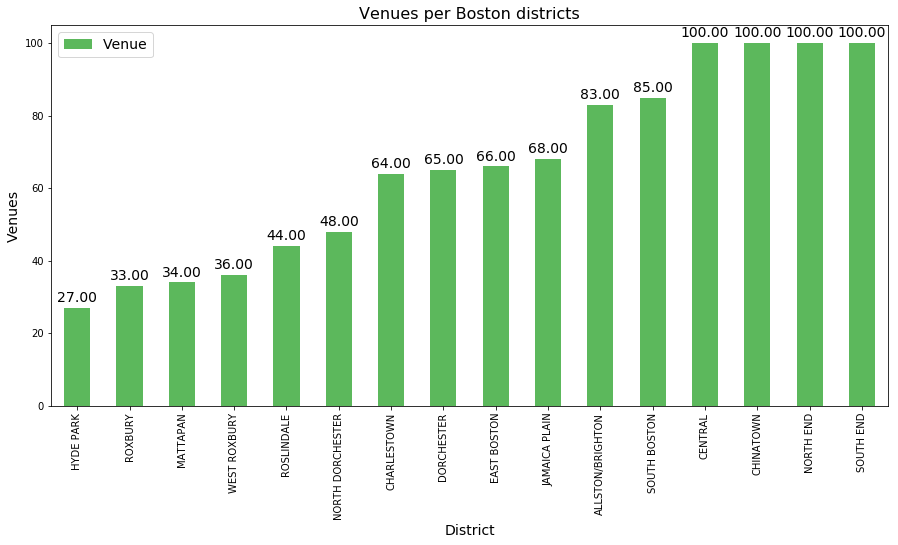

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
bcolors = ['#5cb85c','#5bc0de','#d9534f']
bwidth = 0.5

ax = df_viz.plot(kind='bar', figsize=(15, 7), color = bcolors, width = bwidth, legend=True)

ax.set_title("Venues per Boston districts", fontsize = 16)
ax.set_ylabel('Venues', fontsize = 14)
ax.set_xlabel('District', fontsize = 14)
ax.legend(fontsize = 14)
for p in ax.patches:
    #ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()))
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),fontsize=14, ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax

In [47]:
bos_onehot = pd.get_dummies(bos_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bos_onehot['NEIGH'] = bos_venues['NEIGH'] 

# move neighborhood column to the first column
fixed_columns = [bos_onehot.columns[-1]] + list(bos_onehot.columns[:-1])
bos_onehot = bos_onehot[fixed_columns]

bos_onehot.head()

,NEIGH,ATM,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,HYDE PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HYDE PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HYDE PARK,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HYDE PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HYDE PARK,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
bos_grouped = bos_onehot.groupby('NEIGH').mean().reset_index()
bos_grouped.head()

,NEIGH,ATM,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,ALLSTON/BRIGHTON,0.000000,0.00,0.0,0.0,0.0,0.012048,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.012048,0.012048,0.00,0.000000,0.0
1,CENTRAL,0.000000,0.02,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.010000,0.000000,0.02,0.000000,0.0
2,CHARLESTOWN,0.015625,0.00,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0
3,CHINATOWN,0.000000,0.00,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,...,0.0,0.01,0.0,0.0,0.01,0.020000,0.000000,0.00,0.010000,0.0
4,DORCHESTER,0.000000,0.00,0.0,0.0,0.0,0.030769,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.015385,0.0


In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 10


indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGH']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NEIGH'] = bos_grouped['NEIGH']

for ind in np.arange(bos_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bos_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,NEIGH,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALLSTON/BRIGHTON,Pizza Place,Café,Pub,Bakery,Donut Shop,Chinese Restaurant,Grocery Store,Sushi Restaurant,Coffee Shop,Bank
1,CENTRAL,Seafood Restaurant,American Restaurant,Spa,Hotel,Ice Cream Shop,Coffee Shop,Sporting Goods Shop,Gym,Gym / Fitness Center,Plaza
2,CHARLESTOWN,Donut Shop,Park,Café,Gastropub,History Museum,Pizza Place,Gym,American Restaurant,Grocery Store,Bar
3,CHINATOWN,Asian Restaurant,Sandwich Place,Coffee Shop,Bakery,Chinese Restaurant,Theater,Seafood Restaurant,Sushi Restaurant,Performing Arts Venue,Italian Restaurant
4,DORCHESTER,Pizza Place,Park,Donut Shop,Pharmacy,Metro Station,Café,Plaza,Playground,Chinese Restaurant,Convenience Store


In [52]:
bos_grouped_clustering = bos_grouped.drop('NEIGH', 1)

In [53]:
bos_grouped_clustering.head()

,ATM,Accessories Store,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0.000000,0.00,0.0,0.0,0.0,0.012048,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.012048,0.012048,0.00,0.000000,0.0
1,0.000000,0.02,0.0,0.0,0.0,0.040000,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.010000,0.000000,0.02,0.000000,0.0
2,0.015625,0.00,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.0
3,0.000000,0.00,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.07,...,0.0,0.01,0.0,0.0,0.01,0.020000,0.000000,0.00,0.010000,0.0
4,0.000000,0.00,0.0,0.0,0.0,0.030769,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.00,0.000000,0.000000,0.00,0.015385,0.0


In [54]:
from sklearn import metrics 
from scipy.spatial.distance import cdist

### Finding the correct k using elbow method:

1 : 0.1493841494557285
2 : 0.13178777884274798
3 : 0.12208857094128721
4 : 0.1085856313596679
5 : 0.09641169236114357
6 : 0.08945124620283397
7 : 0.08261352740739115
8 : 0.0701433028176936
9 : 0.06013684130289934
10 : 0.05194129277006325
11 : 0.043555562087017816
12 : 0.035600508666379684
13 : 0.025301725953725533
14 : 0.018058128491938552
15 : 0.009013878188659973
16 : 2.15256891937284e-18


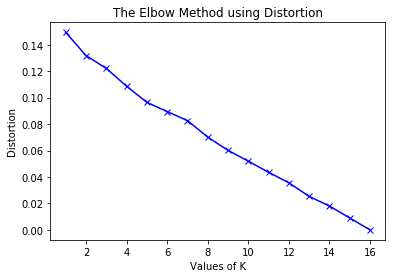

1 : 0.38331242412102107
2 : 0.306387802135844
3 : 0.2629637511586796
4 : 0.22543173336004513
5 : 0.1875757154512902
6 : 0.15959704505377698
7 : 0.1351715554797655
8 : 0.1161972185025516
9 : 0.09310869437359967
10 : 0.0770938154808661
11 : 0.061517783654301265
12 : 0.04664651378058478
13 : 0.033070203334189405
14 : 0.0208702033341894
15 : 0.0104
16 : 0.0


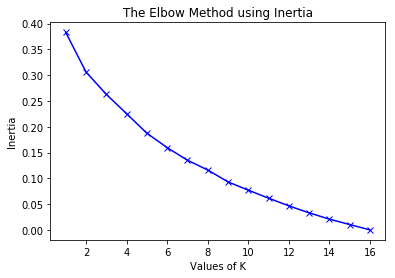

In [55]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,17) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(bos_grouped_clustering) 
    kmeanModel.fit(bos_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / bos_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(bos_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / bos_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 


plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

### Finding the correct k using silhouette method:

[0.3265729968349408, 0.17877623161652528, 0.06866829411816493, 0.07261489152261118, 0.06354914284137991, 0.0660454046980577, 0.06725182950057314, 0.05739510008231946, 0.054059814100808436, 0.04651530408097829, 0.04140722331973737, 0.035584718598127146, 0.024426706061223734, 0.007110225354338441]


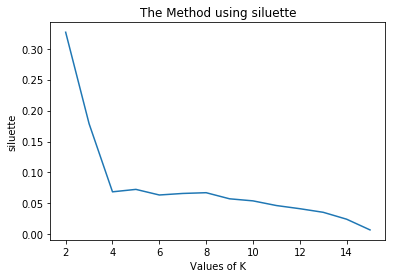

In [57]:
from sklearn.metrics import silhouette_score

silt = []
kmax = 15
K = []
# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(bos_grouped_clustering)
  labels = kmeans.labels_
  silt.append(silhouette_score(bos_grouped_clustering, labels, metric = 'euclidean'))
  K.append(k)
print (silt)
plt.plot(K, silt) 
plt.xlabel('Values of K') 
plt.ylabel('siluette') 
plt.title('The Method using siluette') 
plt.show() 

### Let use 4, as a k, while another minimum is to much for 17 neighborohoods:

In [58]:
kclusters = 4

bos_grouped_clustering = bos_grouped.drop('NEIGH', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bos_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 0, 3, 0, 0, 0, 2, 2, 2], dtype=int32)

In [59]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bos_merged = df_lib

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bos_merged = bos_merged.join(neighborhoods_venues_sorted.set_index('NEIGH'), on='NEIGH')
bos_merged.head(2)

,index,Longitude,Latitude,NEIGH,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,-71.122136,42.257104,HYDE PARK,0,American Restaurant,Pharmacy,Pizza Place,Park,Grocery Store,Donut Shop,Theater,Sandwich Place,Business Service,Discount Store
1,3,-71.111099,42.320646,JAMAICA PLAIN,2,Mexican Restaurant,Sandwich Place,American Restaurant,Coffee Shop,Liquor Store,Bakery,Grocery Store,Brewery,Yoga Studio,Ice Cream Shop


# Part V: Cluster analisys:

### Preprocessing for vizualization:

In [60]:
df_fin['District'] = df_fin['District'].str.upper()

In [61]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

In [62]:
def cluster_details(cluster_label):
    df_cl = bos_merged.loc[bos_merged['Cluster Labels'] == cluster_label, bos_merged.columns[[3] + list(range(4, bos_merged.shape[1]))]]
    
    df_cl_m = df_cl[['NEIGH']]
    df_cl_m.rename(columns = {'NEIGH' : 'District'}, inplace = True)
    df_cl_res = pd.merge(df_cl_m, df_fin, on='District', how='left')
    avg_cr_rate = round(df_cl_res['INCIDENT_NUMBER'].mean(), 2)
    if np.isnan(avg_cr_rate):
        avg_cr_rate = "Please, refer to choropleth map"
    
    del df_cl['Cluster Labels']
    neighs = (df_cl['NEIGH']).to_list()
    neighs = ", ".join(neighs)
    #del df_cl['NEIGH']
    del df_cl['NEIGH']
    df_cl = df_cl.apply(pd.value_counts)
    df_cl['Total'] = df_cl.sum(axis=1)
    df_cl.sort_values(by = 'Total', inplace = True)
    cl_viz = df_cl['Total'].plot (kind = 'barh', color = ['g', 'b', 'y'], figsize=(15, 7), width = 0.6, title =
                                  ("Neighborohoods in cluster: {neighs}. Average crime rate = {avg_cr_rate}".format(neighs=neighs, avg_cr_rate=avg_cr_rate)))
    return (cl_viz)

### Cluster 0:

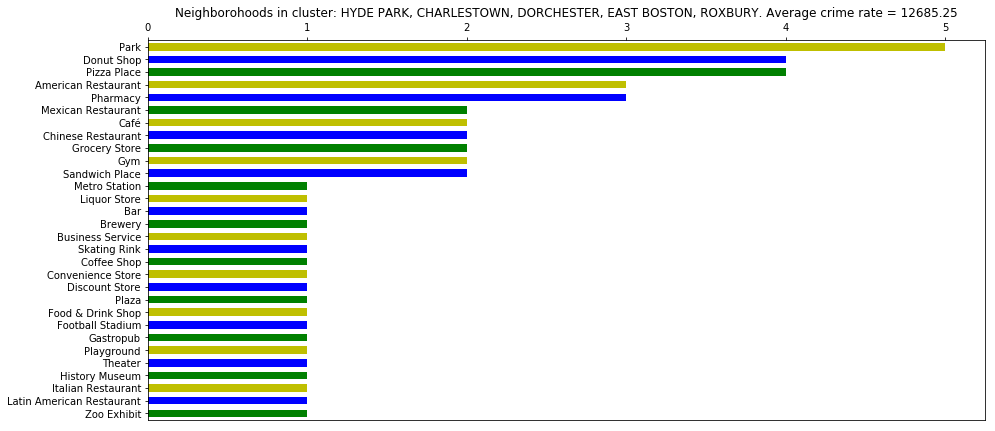

In [64]:
cl_viz1 = cluster_details(0)

This cluster has the highest number of parks - 5, and a lot of place to eat. Also, a metro station is among popular venues, and a lot of places to
spend free time, like zoo, museum, theatre, football studium, skating rink. Store and shops, even plaza are there. There are restaurants of different cultures. It has the lowest average crime, in spite of the most criminal Roxbury, which can be explained by low crime rate of East Boston and Charlestown. Looks very convenient to live. Let it be:

In [65]:
cl_name = []
cl_0_name = 'Nature/Active outdoor/Shopping/VarietyFood'
cl_name.append(cl_0_name)

### Cluster 1:

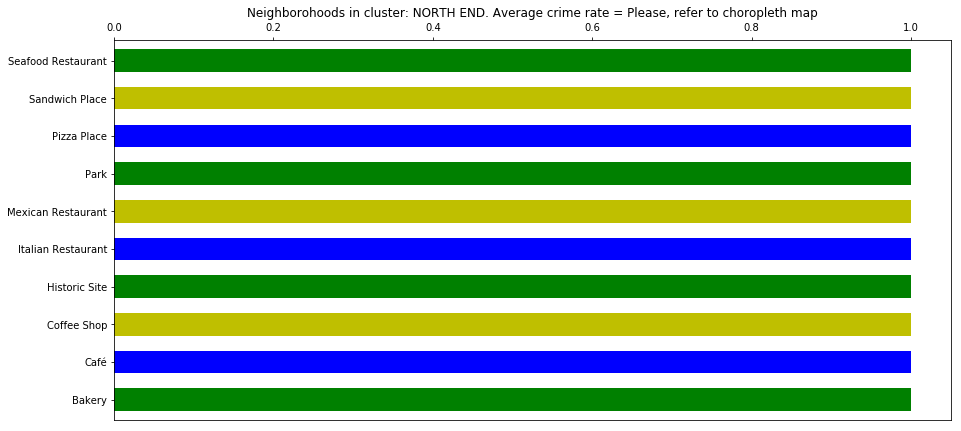

In [66]:
cl_viz2 = cluster_details(1)

North End is always a member of the separate cluster. It can be explained by its busy location near the main Boston transport flow system. It's a
historical site, as the same venue displays, with a lot of tourist and point of interests for them. The crime rate is a typical for dense populate
city center - between 20 - 25 thousand incident in 2 past years. The most of the venues are restaurants. So the previous fact, the park and reach history of place make it:

In [67]:
cl_1_name = 'Sights/Dinner'
cl_name.append(cl_1_name)

### Cluster 2:

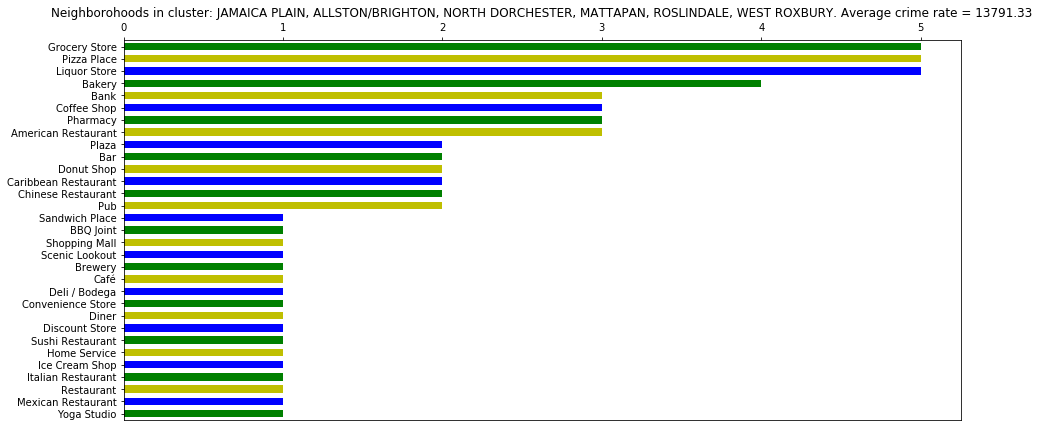

In [68]:
cl_viz3 = cluster_details(2)

The dominant venues of the cluster are food places, with world wide national cuisines. Some plazas, farmacies and mall give an opportunity for
shopping and commercial activities together with banks. The average crime rate is a bit higher than in cluster 0.

In [69]:
cl_2_name = 'CuisinesDiversity/Shopping'
cl_name.append(cl_2_name)

### Cluster 3:

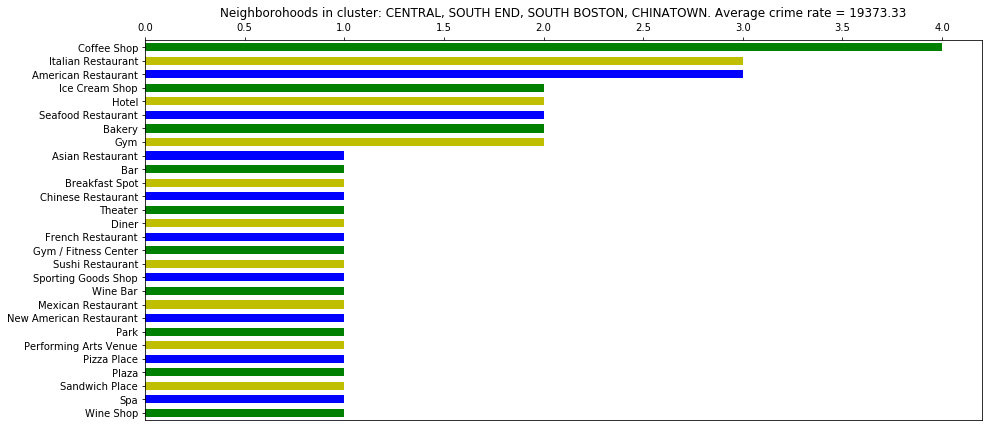

In [70]:
cl_viz4 = cluster_details(3)

With variety of restaurants, park, theater, art center, gyms and hotels the clustered area looks extremely lively and attractive, but locals may suffer due to lack of shopping places, like grocery stores, farmacies, etc. But it's central Boston area with dense population, a lot of tourists and a higher average crime rate. But entertainments are in close proximity!

In [71]:
cl_3_name = 'Culture/Food/Center'
cl_name.append(cl_3_name)

In [72]:
cl_name

['Nature/Active outdoor/Shopping/VarietyFood',
 'Sights/Dinner',
 'CuisinesDiversity/Shopping',
 'Culture/Food/Center']

### Prepare cluster names

In [73]:
cl_name_df = pd.DataFrame(cl_name)
cl_name_df.reset_index(drop = False, inplace = True)
cl_name_df.columns = ['Cluster Labels', "Cluster Name"]
bos_merged = pd.merge(bos_merged, cl_name_df, on='Cluster Labels')

### Map:

In [74]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
#for lat, lon, poi, cluster in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['NEIGH'], bos_merged['Cluster Labels']):
for lat, lon, poi, cluster, name in zip(bos_merged['Latitude'], bos_merged['Longitude'], bos_merged['NEIGH'], bos_merged['Cluster Labels'],
                                       bos_merged['Cluster Name']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' - ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_boston)
       
map_boston